In [1]:
import numpy as np
import pandas as pd

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [2]:
train.drop(columns=['Unnamed: 0','id'],inplace=True)
test.drop(columns=['Unnamed: 0'],inplace=True)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156620 entries, 0 to 156619
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  156620 non-null  int64  
 1   weight(kg)           156620 non-null  int64  
 2   waist(cm)            156620 non-null  float64
 3   hearing(left)        156620 non-null  int64  
 4   hearing(right)       156620 non-null  int64  
 5   systolic             156620 non-null  int64  
 6   relaxation           156620 non-null  int64  
 7   fasting blood sugar  156620 non-null  int64  
 8   Cholesterol          156620 non-null  int64  
 9   triglyceride         156620 non-null  int64  
 10  HDL                  156620 non-null  int64  
 11  LDL                  156620 non-null  int64  
 12  hemoglobin           156620 non-null  float64
 13  Urine protein        156620 non-null  int64  
 14  serum creatinine     156620 non-null  float64
 15  AST              

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
# Load and prepare your dataset (X, y)
y=train['smoking']
X=train.drop(columns=['smoking'])


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [4]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="binary:logistic",
    gamma=1,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=5,
    n_estimators=1000,
    random_state=42,
    
    booster='gbtree',
    subsample=0.8,#0.08
    tree_method='hist',
    eval_metric='logloss'
)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"XGBoost with GPU Accuracy: {accuracy}")
conf_matrix = confusion_matrix(y_test, xgb_y_pred)
print("Confusion Matrix:")
print(conf_matrix)



XGBoost with GPU Accuracy: 0.7835525475673605
Confusion Matrix:
[[13625  4137]
 [ 2643 10919]]


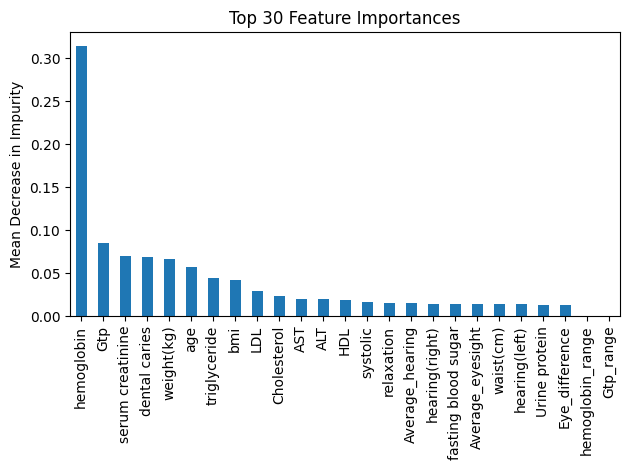

In [5]:
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
xgb_importances = pd.Series(importances, index=X.columns)


xgb_importances_sorted = xgb_importances.sort_values(ascending=False)

# Select the top 20 features
top_20_features = xgb_importances_sorted[:30]

# Create the bar plot for the top 20 features
fig, ax = plt.subplots()
top_20_features.plot.bar(ax=ax)
ax.set_title('Top 30 Feature Importances')
ax.set_ylabel('Mean Decrease in Impurity')
plt.xticks(rotation=90)  # Optional: Rotate x-axis labels for better readability
fig.tight_layout()
plt.show()

In [6]:
test_data_pred=test.copy()
test_data_pred.drop(columns=['id'],inplace=True)
test.head()

test_data_pred=scaler.transform(test_data_pred)
w_pred=pd.DataFrame({
    'id': test.id,
      'xgb_smoking':xgb_model.predict(test_data_pred)})

w_pred.to_csv('xgb.csv',index=False)